#  **COVID-19 Pandemic Forecasting Using LSTM**




The COVID-19 (coronavirus disease 2019) is an infectious disease that caused by the SARS-CoV-2 virus and was first reported in China in late 2019, as the cause of a new type of pneumonia [1]. Even though, use of Covid-19 vaccines led to a decrease in mortality rate, mutations of the virus can cause new COVID-19 surges. To minimize the number of infected cases, many countries followed procedures that included getting vaccination, quarantine, online schools and businesses, and bans on travel [2, 3].

The COVID-19 pandemic has fundamentally altered the worldwide landscape and dramatically changed people’s lives and behaviors.It is crucial to determine the spread rate to help governments to plan public health and develop policies and strategies to minimize the risk of transmission COVID-19. It also allows companies to have ideas of the demand so that they can act accordingly and plan their way out. To determine the COVID-19 spread rate is to accurately predict the number of  cases at a given time. 

Deep learning techniques have been used for a prediction of the COVID-19 and feeding it into demand forecasting. Since the COVID-19 pandemic has shifted into a global pandemic, the real-time data examinations are required to provide the population with a strong course of action to combat the infection.

The primary objective of the project was to perform the exploratory data analysis and to aid in the accurate forecasting of confirmed COVID-19 cases by using Long Short-Term Memory (LSTM) architecture, a deep learning technique for building the time-series forecasting model. 



[1] World Health Organization (WHO), “Coronavirus disease (COVID-19) pandemic,” 2020, https://www.euro.who.int/en/health-topics/health-emergencies/coronavirus-covid-19/novel-coronavirus-2019-ncov.
View at: Google Scholar

[2] M. Ozaslan, M. Safdar, I. H. Kilic, and R. A. Khailan, “Practical measures to prevent COVID-19: a mini-review,” Journal of Biological Sciences, vol. 20, no. 2, 2020.
View at: Publisher Site | Google Scholar

[3] M. U. G. Kraemer, C.-H. Yang, B. Gutierrez et al., “The effect of human mobility and control measures on the COVID-19 epidemic in China,” Science, vol. 368, no. 6490, pp. 493–497, 2020.
View at: Publisher Site | Google Scholar

**Data Collection**

Dataset

The data for this analysis came from [Our World in Data](https://github.com/owid/covid-19-data.git)'s complete COVID-19 dataset. It will be updated daily throughout the duration of the COVID-19 pandemic. It includes the following data:
- Vaccinations -- Official data collated by the Our World in Data
- Tests & positivity -- Official data collated by the Our World in Data
- Hospital & ICU -- Official data collated by the Our World in Data
- Confirmed cases -- JHU CSSE COVID-19 Data
- Confirmed deaths -- JHU CSSE COVID-19 Data
- Reproduction rate -- Arroyo-Marioli F, Bullano F, Kucinskas S, Rondón-Moreno C
- Policy responses -- Oxford COVID-19 Government Response Tracker
- Other variables of interest -- International organizations (UN, World Bank, OECD, IHME…)

## Import related libraries

In [ ]:
#Import Libraries
!pip install plotly==4.8.2

# importing the required libraries
import numpy as np 
import pandas as pd 
import random
import math
import time
from datetime import date, timedelta

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Model,Sequential
from keras.layers import Dense, LSTM, Dropout, Input, Activation, Flatten, BatchNormalization,SeparableConv1D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers.convolutional import Conv2D, MaxPooling2D,Conv1D
from keras.layers.recurrent import LSTM

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# library to handle requests
import requests 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 
from pandas import read_csv

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
# Visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins
from folium.plugins import MarkerCluster, HeatMap
from folium import Marker

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12
# Disable warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Google Drive
from google.colab import drive
drive.mount('/content/drive')



     |████████████████████████████████| 11.5 MB 3.2 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=5b07a9d40528bf1ba77ab558014294ef151e5d981049c48d24e7797b7b9367c3
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
Mounted at /content/drive


# Data Prep and Data Cleaning


> ## **World data: total confirmed cases updated everyday since DAY 1 (2020-02-24) by country**


Extracting data from the JHU Github repository

In [ ]:
#Data daily (since day 1)
covid_cases_owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
covid_cases_owid.drop(["continent"],axis=1, inplace=True)
covid_cases_owid = covid_cases_owid.apply(lambda x: x.fillna(0) if x.dtype.kind in 'float64' else x)
to_drop = ['South America',
'Sint Maarten (Dutch part)',
'Africa',
'Asia',
'Europe',
'European Union',
'North America',	
'Northern Cyprus',
'International',
'World']


covid_cases_owid = covid_cases_owid[~covid_cases_owid.iso_code.str.contains("OWID")]

covid_cases_owid = covid_cases_owid[~covid_cases_owid['location'].isin(to_drop)]

#rename cols
covid_cases_owid = covid_cases_owid.rename(columns={'total_vaccinations_per_hundred': 'total_vaccinations_%', 'people_vaccinated_per_hundred': 'people_vaccinated_%', 'people_fully_vaccinated_per_hundred': 'people_fully_vaccinated_%', 'total_boosters_per_hundred':'total_boosters_%'})


In [ ]:
# Drop some unused cols

covid_cases_owid.drop([ "new_tests",
                       "total_deaths_per_million",  "hosp_patients_per_million", "icu_patients_per_million","weekly_icu_admissions","weekly_icu_admissions_per_million","weekly_hosp_admissions","weekly_hosp_admissions_per_million",
                                          "total_tests_per_thousand", "new_tests_per_thousand", "new_tests_smoothed", "new_tests_smoothed_per_thousand",
                                          "tests_per_case", "tests_units", "new_vaccinations_smoothed", 
                                          "population_density",'reproduction_rate',"excess_mortality",
                                          "new_vaccinations_smoothed_per_million",	"stringency_index", "hospital_beds_per_thousand",
                       'median_age',	'aged_65_older'	,'aged_70_older'	,'gdp_per_capita',	'extreme_poverty'	,'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million','cardiovasc_death_rate',	'diabetes_prevalence',	'female_smokers',	'male_smokers',	'handwashing_facilities',	'life_expectancy',	'human_development_index'],axis=1, inplace=True)


In [ ]:
covid_cases_owid.head()

iso_code     location  ... new_people_vaccinated_smoothed_per_hundred  population
0      AFG  Afghanistan  ...                                        0.0  39835428.0
1      AFG  Afghanistan  ...                                        0.0  39835428.0
2      AFG  Afghanistan  ...                                        0.0  39835428.0
3      AFG  Afghanistan  ...                                        0.0  39835428.0
4      AFG  Afghanistan  ...                                        0.0  39835428.0

[5 rows x 30 columns]

In [ ]:
# covid_cases_owid['date'] = pd.to_datetime(covid_cases_owid['date'],format='%Y-%m-%d')


> ## **World data: latest total cases**

In [ ]:
#Cummulative data
latest_data_owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/latest/owid-covid-latest.csv')

# df['DataFrame Column'] = df['DataFrame Column'].fillna(0)
latest_data_owid = latest_data_owid.apply(lambda x: x.fillna(0) if x.dtype.kind in 'float64' else x)

#Remove continent rows
to_drop = ['South America',
'Sint Maarten (Dutch part)',
'Africa',
'Asia',
'Europe',
'European Union',
'North America',	
'Northern Cyprus',
'International',
'World']
latest_data_owid = latest_data_owid[~latest_data_owid['location'].isin(to_drop)]

iso_to_drop = ['OWID_HIC'] 

# latest_data_owid = latest_data_owid[~latest_data_owid['iso_code'].isin(iso_to_drop)]
latest_data_owid = latest_data_owid[~latest_data_owid.iso_code.str.contains("OWID")]

# latest_data_owid['vaccinated_people_%'] = (latest_data_owid['people_vaccinated']/latest_data_owid['population'])*100

# latest_data_owid = latest_data_owid.drop(latest_data_owid.index[[1,10,66,65,93,147,184, 218,149]])

latest_data_owid = latest_data_owid.rename(columns={'total_vaccinations_per_hundred': 'total_vaccinations_%', 'people_vaccinated_per_hundred': 'people_vaccinated_%', 'people_fully_vaccinated_per_hundred': 'people_fully_vaccinated_%', 'total_boosters_per_hundred':'total_boosters_%'})

latest_data_owid.drop(["continent", "new_tests", "new_cases_smoothed","new_deaths_smoothed","new_cases_smoothed_per_million","new_deaths_smoothed_per_million",
                       "total_deaths_per_million", "new_deaths_per_million", "hosp_patients_per_million", "icu_patients_per_million","weekly_icu_admissions","weekly_icu_admissions_per_million","weekly_hosp_admissions","weekly_hosp_admissions_per_million",
                                          "total_tests_per_thousand", "new_tests_per_thousand", "new_tests_smoothed", "new_tests_smoothed_per_thousand",
                                          "tests_per_case", "tests_units", "new_vaccinations_smoothed", 
                                          "population_density",'reproduction_rate',"excess_mortality",
                                          "new_vaccinations_smoothed_per_million",	"stringency_index", "hospital_beds_per_thousand",
                       'median_age',	'aged_65_older'	,'aged_70_older'	,'gdp_per_capita',	'extreme_poverty'	,'cardiovasc_death_rate',	'diabetes_prevalence',	'female_smokers',	'male_smokers',	'handwashing_facilities',	'life_expectancy',	'human_development_index'],axis=1, inplace=True)

# latest_data_owid['last_updated_date'] = pd.to_datetime(latest_data_owid['last_updated_date'],format='%Y-%m-%d')


In [ ]:
latest_data_owid = latest_data_owid[latest_data_owid['iso_code'].str.len()<=3]
latest_data_owid.head()

iso_code  ... excess_mortality_cumulative_per_million
0      AFG  ...                                     0.0
2      ALB  ...                                     0.0
3      DZA  ...                                     0.0
4      AND  ...                                     0.0
5      AGO  ...                                     0.0

[5 rows x 28 columns]

\

> ## **Vaccine Data**


**location**: name of the country (or region within a country).

**iso_code**: ISO 3166-1 alpha-3 – three-letter country codes.

**date**: date of the observation.

**total_vaccinations**: total number of doses administered. For vaccines that require multiple doses, each individual dose is counted. If a person receives one dose of the vaccine, this metric goes up by 1. If they receive a second dose, it goes up by 1 again. If they receive a third/booster dose, it goes up by 1 again.

**total_vaccinations_per_hundred:** total_vaccinations per 100 people in the total population of the country.

**daily_vaccinations_raw**: daily *change* in the total number of doses administered. It is only calculated for consecutive days. This is a raw measure provided for data checks and transparency, but we strongly recommend that any analysis on daily vaccination rates be conducted using 
**daily_vaccinations** instead.

**daily_vaccinations**: new doses administered per day (7-day smoothed). For countries that don't report data on a daily basis, we assume that doses changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window. An example of how we perform this calculation can be found here.

**daily_vaccinations_per_million**: daily_vaccinations per 1,000,000 people in the total population of the country.

**people_vaccinated**: total number of people who received at least one vaccine dose. If a person receives the first dose of a 2-dose vaccine, this metric goes up by 1. If they receive the second dose, the metric stays the same.

**people_vaccinated_per_hundred**: people_vaccinated per 100 people in the total population of the country.

**people_fully_vaccinated**: total number of people who received all doses prescribed by the vaccination protocol. If a person receives the first dose of a 2-dose vaccine, this metric stays the same. If they receive the second dose, the metric goes up by 1.

**people_fully_vaccinated_per_hundred:** people_fully_vaccinated per 100 people in the total population of the country.

**Note**: for people_vaccinated and people_fully_vaccinated we are dependent on the necessary data being made available, so we may not be able to make these metrics available for some countries.

### **By Bands and Total Vaccination in each day**

In [ ]:
# - Vaccination 
vaccine_by_brand = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv')

vaccine_by_brand.fillna(0, inplace = True)
# vaccine_by_brand['date'] = pd.to_datetime(vaccine_by_brand['date'],format='%Y-%m-%d')

vaccine_by_brand.head()

location        date             vaccine  total_vaccinations
0  Austria  2021-01-08     Johnson&Johnson                   0
1  Austria  2021-01-08             Moderna                   0
2  Austria  2021-01-08  Oxford/AstraZeneca                   0
3  Austria  2021-01-08     Pfizer/BioNTech               31616
4  Austria  2021-01-15     Johnson&Johnson                   0

### **Lastest update of total vacc in each Country**





In [ ]:
country_vaccine = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/locations.csv')
# country_vaccine['last_observation_date'] = pd.to_datetime(country_vaccine['last_observation_date'],format='%Y-%m-%d')

country_vaccine.head()

location  ...                                     source_website
0  Afghanistan  ...                           https://covid19.who.int/
1      Albania  ...  https://shendetesia.gov.al/vaksinimi-anticovid...
2      Algeria  ...                           https://covid19.who.int/
3      Andorra  ...                           https://covid19.who.int/
4       Angola  ...                           https://covid19.who.int/

[5 rows x 6 columns]

In [ ]:
#Check if there is any NA or null

country_vaccine.isna().any()

location                 False
iso_code                 False
vaccines                 False
last_observation_date    False
source_name              False
source_website           False
dtype: bool

### **Where each vaccine is being used (no. of countries)**





In [ ]:
vaccine_by_brand2 = country_vaccine.drop(columns=['iso_code',	'last_observation_date',	'source_name',	'source_website'])
vaccine_by_brand2 = vaccine_by_brand2.drop('vaccines', axis=1).join(vaccine_by_brand2['vaccines'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('vaccine brands'))

vaccine_by_brand3 = vaccine_by_brand2.groupby(['vaccine brands', 'location']).size().reset_index(name='counts').sort_values('vaccine brands')
vaccine_by_brand3['vaccine brands'] = vaccine_by_brand3['vaccine brands'].str.replace(" ", "")
vaccine_by_brand3 = vaccine_by_brand3.groupby('vaccine brands').nunique().reset_index()
vaccine_by_brand3 = vaccine_by_brand3.drop(columns=['counts'])

vaccine_by_brand3.info

<bound method DataFrame.info of         vaccine brands  location
0               Abdala         4
1       COVIranBarekat         1
2              CanSino         7
3              Covaxin         9
4         EpiVacCorona         2
5      Johnson&Johnson        82
6              Medigen         1
7              Moderna        88
8              Novavax         2
9   Oxford/AstraZeneca       182
10     Pfizer/BioNTech       153
11              QazVac         2
12   Sinopharm/Beijing        86
13     Sinopharm/Wuhan         2
14             Sinovac        48
15          Soberana02         4
16        SputnikLight         7
17            SputnikV        59
18            Turkovac         1
19              ZF2001         3>

### **Combine Vaccine data with brands of vaccines used in each countries (total updated in everyday)...sorted by country**





The dataset contains the following information:

Country - this is the country for which the vaccination information is provided;

Country ISO Code - ISO code for the country;

Date- date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;

Total_vaccinations - total number of doses administered. For vaccines that require multiple doses, each individual dose is counted. If a person receives one dose of the vaccine, this metric goes up by 1. If they receive a second dose, it goes up by 1 again. If they receive a third/booster dose, it goes up by 1 again.;

Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;

Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;

Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;

Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;

Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;

Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;

Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;

Number of vaccinations per day - number of daily vaccination for that day and country;

Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;

Vaccines used in the country - total number of vaccines used in the country (up to date);

Source name - source of the information (national authority, international organization, local organization etc.);

Source website - website of the source of information;



In [ ]:
vaccine = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')

#Merge dataframes
vaccine_combined = vaccine.merge(country_vaccine, left_on="location", right_on="location")

#Drop
vaccine_combined = vaccine_combined.drop(columns=['last_observation_date','source_name','iso_code_y','source_website'])

#Re-order columns
cols_to_order = ['location', 'iso_code_x','vaccines']
new_columns = cols_to_order + (vaccine_combined.columns.drop(cols_to_order).tolist())
vaccine_combined = vaccine_combined[new_columns]

#Rename
vaccine_combined = vaccine_combined.rename(columns={"iso_code_x": "iso_code", 'total_vaccinations_per_hundred': 'total_vaccinations_%', 'people_vaccinated_per_hundred': 'people_vaccinated_%', 
                                                    'people_fully_vaccinated_per_hundred': 'people_fully_vaccinated_%', 'total_boosters_per_hundred':'total_boosters_%'})
vaccine = vaccine[vaccine['iso_code'].str.len()<=3]
vaccine_combined = vaccine_combined.apply(lambda x: x.fillna(0) if x.dtype.kind in 'float64' else x)

# vaccine_combined['date'] = pd.to_datetime(vaccine_combined['date'],format='%Y-%m-%d')

vaccine_combined 
# vaccine_combined.info()


location  ... daily_people_vaccinated_per_hundred
0      Afghanistan  ...                               0.000
1      Afghanistan  ...                               0.003
2      Afghanistan  ...                               0.003
3      Afghanistan  ...                               0.003
4      Afghanistan  ...                               0.003
...            ...  ...                                 ...
77704     Zimbabwe  ...                               0.020
77705     Zimbabwe  ...                               0.021
77706     Zimbabwe  ...                               0.020
77707     Zimbabwe  ...                               0.021
77708     Zimbabwe  ...                               0.020

[77709 rows x 17 columns]

### **Which categories of vaccines is offered?**


In [ ]:
grp = ['location', 'total_vaccinations', 'iso_code', 'vaccines','people_fully_vaccinated_%']
vacc_no = vaccine_combined[grp].groupby('vaccines').max().sort_values('people_fully_vaccinated_%', ascending=False).dropna(subset=['total_vaccinations'])
vacc_no

location  ...  people_fully_vaccinated_%
vaccines                                                                      ...                           
Pfizer/BioNTech                                     Turks and Caicos Islands  ...                     121.14
Oxford/AstraZeneca                                                   Vanuatu  ...                     100.00
Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/...      United Arab Emirates  ...                      94.24
Johnson&Johnson, Moderna, Oxford/AstraZeneca, P...                     Spain  ...                      91.36
Johnson&Johnson, Moderna, Oxford/AstraZeneca, P...                    Kuwait  ...                      91.36
...                                                                      ...  ...                        ...
Johnson&Johnson, Oxford/AstraZeneca, Sinopharm/...                     Syria  ...                       6.36
Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bio...                     Sudan  ...                       4.42
Johnson&Johnson, Moderna, Pfizer/BioNTech, Sino...                  Tanzania  ...                       2.79
Johnson&Johnson, Oxford/AstraZeneca, Sinovac                           Yemen  ...                       1.21
Johnson&Johnson, Moderna                                               Haiti  ...                       0.81

[81 rows x 4 columns]

### **The US vaccination data**


In [ ]:
us_state_vaccinations = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')
us_state_vaccinations = us_state_vaccinations.apply(lambda x: x.fillna(0) if x.dtype.kind in 'float64' else x)
us_state_vaccinations = us_state_vaccinations.rename(columns={'total_vaccinations_per_hundred': 'total_vaccinations_%', 'people_vaccinated_per_hundred': 'people_vaccinated_%', 'people_fully_vaccinated_per_hundred': 'people_fully_vaccinated_%', 'total_boosters_per_hundred':'total_boosters_%', 'distributed_per_hundred': 'distributed_%'})
# us_state_vaccinations['date'] = pd.to_datetime(us_state_vaccinations['date'],format='%Y-%m-%d')

us_state_vaccinations.head()

date location  ...  total_boosters  total_boosters_%
0  2021-01-12  Alabama  ...             0.0               0.0
1  2021-01-13  Alabama  ...             0.0               0.0
2  2021-01-14  Alabama  ...             0.0               0.0
3  2021-01-15  Alabama  ...             0.0               0.0
4  2021-01-16  Alabama  ...             0.0               0.0

[5 rows x 16 columns]


> ## **Variants Data** 
# ❗data(variants): stop sharing variants dataset (GISAID request)




location:	Name of the country (or region within a country).

date:	Date of the observation.

variant:	Variant name. We use the WHO label for Variants of Concern (VoC) and Variants of Interest (VoI), and Pango Lineage for the others. Details on variants included can be found here.

num_sequences:	Number of sequenced samples that fall into the category variant.

perc_sequences:	Percentage of the sequenced samples that fall into the category variant.

num_sequences_total:	Total number of samples sequenced in the last two weeks.

**Special variant values:**

others: All variants/mutations other than the ones specified (i.e. not listed in this table).

non_who: All variants/mutations without WHO label.


**Note that non_who includes others and other variants. For instance, variant B.1.16 is counted in the non_who category but not in others, as it does not have a WHO label but is listed in this table.**


**As a consequence, for a given date, the sum of perc_sequences will exceed 1. In order to sum 1, you should exclude non_who category.**



In [ ]:
#  variants = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/variants/covid-variants.csv')
# variants_SORTED =  variants[COL_variants].groupby(['variant','location']).max()[['num_sequences','perc_sequences']].reset_index()

# variants_SORTED.head()

In [ ]:
variants_SORTED = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid 19 proj/variants_SORTED.csv',index_col=False)


In [ ]:
#Top most inflected countries of top variants: 'Alpha', 'Beta', 'Delta', 'Omicron'
pop_variants = ['Alpha', 'Beta', 'Delta', 'Omicron']
most_inflected_countries = variants_SORTED.loc[variants_SORTED['variant'].isin(pop_variants)]
#column to added from first dataframe to second:
sub_df = latest_data_owid[['iso_code', 'location']]

#Second dataframe after adding column from first dataframe:
# most_inflected_countries = most_inflected_countries.join(extracted_col)

most_inflected_countries = most_inflected_countries.drop('Unnamed: 0', 1)



most_inflected_countries = most_inflected_countries.sort_values(by=['variant','num_sequences'],ascending=False)
most_inflected_countries

variant          location  num_sequences  perc_sequences
2394  Omicron    United Kingdom          10820           54.58
2395  Omicron     United States           1399           33.79
2305  Omicron           Denmark           1028           24.07
2380  Omicron      South Africa            896           95.73
2297  Omicron            Canada            449           53.33
...       ...               ...            ...             ...
11      Alpha          Botswana              0            0.00
13      Alpha            Brunei              0            0.00
83      Alpha  Papua New Guinea              0            0.00
116     Alpha           Uruguay              0            0.00
119     Alpha          Zimbabwe              0            0.00

[480 rows x 4 columns]



---



# EXPLORATORY DATA ANALYSIS AND VISUALIZATION


In [ ]:

latest_data_owid.style.background_gradient(axis=None,cmap='YlOrRd', subset=['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'people_vaccinated_%'])




> ### **World Total COVID-19 Cases since 2020-01-22**




In [ ]:
total_world = covid_cases_owid.drop(['iso_code','location'], axis = 1)
total_world = covid_cases_owid.groupby('date').sum()
total_world = total_world[['total_cases',	'new_cases',	'new_cases_smoothed',	'total_deaths',	'new_deaths',	'new_deaths_smoothed','hosp_patients','people_fully_vaccinated']]
total_world = total_world.reset_index()
total_world.head()



date  total_cases  ...  hosp_patients  people_fully_vaccinated
0  2020-01-01          0.0  ...            0.0                      0.0
1  2020-01-02          0.0  ...            0.0                      0.0
2  2020-01-03          0.0  ...            0.0                      0.0
3  2020-01-04          0.0  ...            0.0                      0.0
4  2020-01-05          0.0  ...            0.0                      0.0

[5 rows x 9 columns]

In [ ]:
# !pip install plotly==5.3.1


In [ ]:
# df_list = [df_confirmed,df_deaths,df_recovered]
cases = ['total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed']
case_color = ['orange','red','green', 'blue']
case_dict = {cases[i]:case_color[i] for i in range(len(cases))}

In [ ]:
tplot = go.Figure()
for case in cases:
    tplot.add_trace(
        go.Scatter(
            x = total_world['date'],
            y = total_world[case],
            name = case,
            line = dict(color=case_dict[case]),
            hovertemplate ='<br><b>Date</b>: %{x}'+'<br><b>Count</b>: %{y}',
        )
    )


tplot.update_layout(
    updatemenus=[
        dict(
        buttons=list(
            [dict(label = 'All Cases',
                  method = 'update',
                  args = [{'visible': [True, True, True, True, True, True, True, True]},
                          {'title': 'World Total COVID-19 Cases since 2020-01-22',
                           'showlegend':True}]),
             dict(label = 'Total Cases',
                  method = 'update',
                  args = [{'visible': [True, False, False, False, True, False, False, False]},
                          {'title': 'Total Cases',
                           'showlegend':True}]),
             dict(label = 'Total Deaths',
                  method = 'update',
                  args = [{'visible': [False, False, False, True, False, False, False, True]},
                          {'title': 'Total Deaths',
                           'showlegend':True}]),
             dict(label = 'New Cases',
                  method = 'update',
                  args = [{'visible': [False, False, True, False, False, False, True, False]},
                          {'title': 'New Cases',
                           'showlegend':True}]),
             dict(label = 'New Deaths',
                  method = 'update',
                  args = [{'visible': [False, True, False, False, False, True, False, False]},
                          {'title': 'New Deaths',
                           'showlegend':True}]),
            ]),type = 'buttons',
             direction="right",
             showactive = True,
             x=-0.25,
             xanchor="left",
             y=1.25,
             yanchor="top"
        ),
        dict(
        buttons=list(
            [dict(label = 'Linear Scale',
                  method = 'relayout',
                  args = [{'yaxis': {'type': 'linear'}},
                          {'title': 'All Cases',
                           'showlegend':True}]),
             dict(label = 'Log Scale',
                  method = 'relayout',
                  args = [{'yaxis': {'type': 'log'}},
                          {'title': 'All Cases',
                           'showlegend':True}]),
            ]),
             direction="right",
             x=-0.25,
             xanchor="left",
             y=1.39,
             yanchor="bottom"
        )
    ])

tplot.update_layout(
    height=600, width=1100, 
    title_text="<b>World Total COVID-19 Cases since 2020-01-22</b>", title_x=0.5, title_font_size=20,
                            legend=dict(orientation='h',yanchor='top',y=1.15,xanchor='right',x=1), paper_bgcolor="white",
                            xaxis_title="Date", yaxis_title="Number of Cases")
tplot.show()


> ### **Distribution of cases**


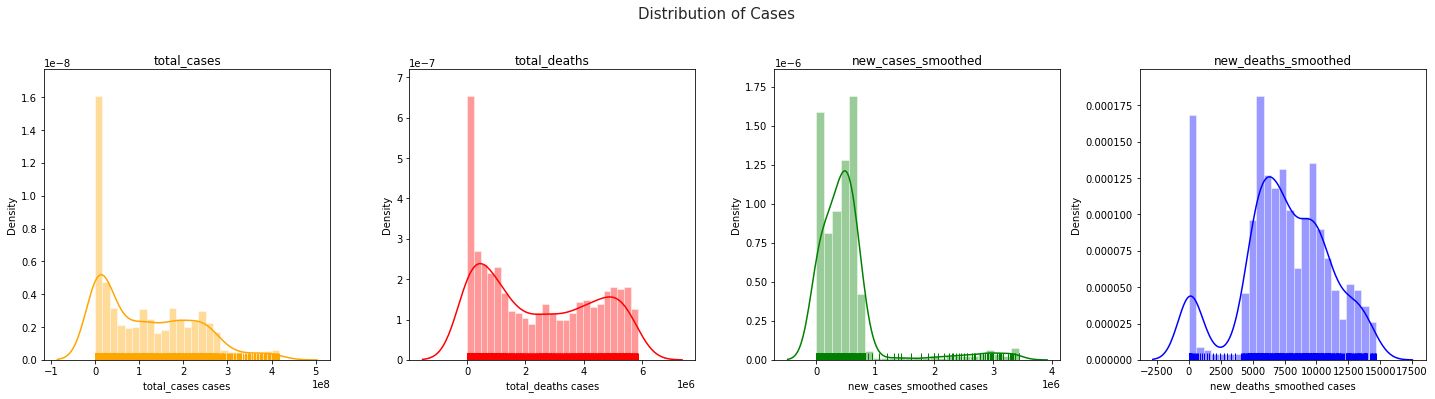

In [ ]:
fig,ax = plt.subplots(1,4,figsize = (20,5))
for i in range(len(cases)):
    sns.set_style('whitegrid')
    sns.distplot(total_world[cases[i]], kde = True, rug = True, bins = 25,ax =ax[i],color = case_color[i])
    ax[i].set_xlabel( cases[i]+ ' cases')
    ax[i].set_ylabel('Density')
    ax[i].set_title(cases[i])
fig.tight_layout()
plt.suptitle('Distribution of Cases',fontsize = 15,y = 1.1)
plt.show()




> ### **Total confirmed cases in each country since Day 1**




In [ ]:
fig = px.line(covid_cases_owid, x = 'date', y ='total_cases', color = 'location', log_y = True)
fig.update_layout(
    title= "Total Confirmed Cases in Each Country",
    xaxis_title="Date",
    yaxis_title="Cases",
    title_x=0.5
)
fig.show()

> ### **POLYGON geometry for maps of total cases and deaths**


In [ ]:
import plotly.express as px
#df = px.data.
#month = confirmed_cases_by_country['']
fig = px.scatter_geo(latest_data_owid, locations="iso_code",color="total_cases",
                     text='total_deaths', size="total_cases",
                     projection="natural earth")
fig.update_layout(
    title={
        'text': "COVID-19 Around the World",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()


> ### **The top 10 most infected countries (confirmed cases) and the top 10 most fatalities countries (deaths)**


In [ ]:
cols = ['location','iso_code', 'total_cases', 'total_deaths']
confirmed_cases_by_country = latest_data_owid[cols].groupby('location').max()[['total_cases','total_deaths']]
confirmed_cases_by_country.sort_values(by=['total_cases','total_deaths'],ascending=False,inplace=True)




In [ ]:
confirmed_cases_by_country = confirmed_cases_by_country.astype({"total_cases":'int', "total_deaths":'int'}) 
confirmed_cases_by_country

total_cases  total_deaths
location                                       
United States            78172840        928518
India                    42754315        510413
Brazil                   27819996        641096
France                   22028827        135924
United Kingdom           18495270        160177
...                           ...           ...
Saint Helena                    4             0
Cook Islands                    2             0
Micronesia (country)            1             0
Guernsey                        0             0
Jersey                          0             0

[216 rows x 2 columns]

<function matplotlib.pyplot.show>

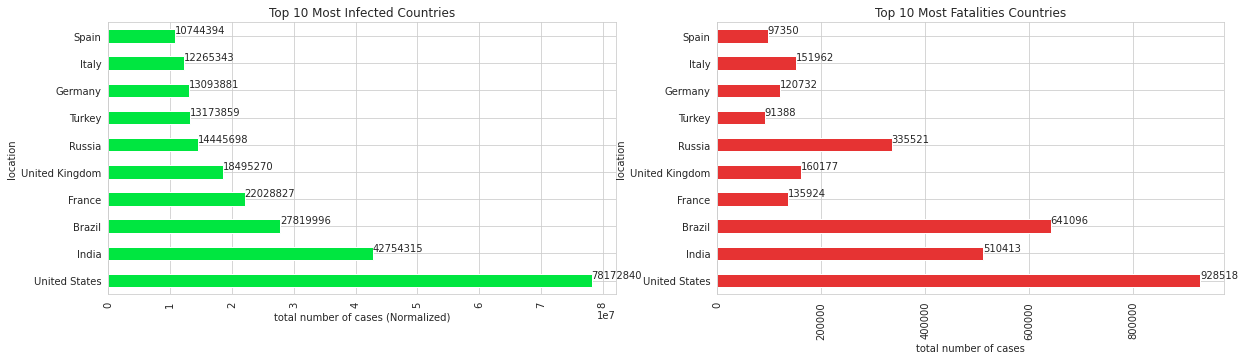

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
confirmed_cases_by_country['total_cases'].head(10).plot(kind='barh',color=(0,0.9,.25,1.0))
plt.xticks(rotation=90)
xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]
for i, v in enumerate(confirmed_cases_by_country['total_cases'].head(10)):
  plt.text(v, xlocs[i]-0.9 , str(v))
plt.xlabel('total number of cases (Normalized)')
plt.title('Top 10 Most Infected Countries')

plt.subplot(1,2,2)
confirmed_cases_by_country['total_deaths'].head(10).plot(kind='barh',color = (0.9,0.2,0.2,1.0))
for i, v in enumerate(confirmed_cases_by_country['total_deaths'].head(10)):
  plt.text(v, xlocs[i]-0.9 , str(v))
plt.xlabel('total number of cases')
plt.title('Top 10 Most Fatalities Countries')
plt.xticks(rotation=90)
plt.show


### **Total vaccinations in each country** 

In [ ]:
trace = go.Choropleth(
            locations = vaccine_combined['location'],
            locationmode='country names',
            z = vaccine_combined['total_vaccinations'],
            text = vaccine_combined['location'],
            autocolorscale =False,
            reversescale = True,
            colorscale = 'viridis',
            marker = dict(
                line = dict(
                    color = 'rgb(0,0,0)',
                    width = 0.5)
            ),
            colorbar = dict(
                title = 'Total Vaccinations',
                tickprefix = '')
        )

data = [trace]
layout = go.Layout(
    title = {'text':'Total Vaccinations per Country','x':0.5,'xanchor': 'center'},
    geo = dict(
        showframe = True,
        showlakes = False,
        showcoastlines = True,
        projection = dict(
            type = 'natural earth'
        )
    )
)



fig = dict( data=data, layout=layout )
iplot(fig)

> ### **No. of countries used each vaccine brand**


Which vaccines are in use?

In [ ]:

fig = px.treemap(vaccine_by_brand3, path = ["location", "vaccine brands"], values = 'location',title="The Number of Countries are Using Each Vaccine")
fig.update_layout(title_x=0.5)

fig.show()


> ### **Different combinations of vaccines have been used**



In [ ]:
import plotly.express as px
fig = px.bar(vacc_no, x=vacc_no.index, y='total_vaccinations',hover_data=['total_vaccinations'], color='total_vaccinations',height=400)
fig.update_layout(    autosize=False,
                  width=1500,
    height=2000,
     uniformtext_mode='hide', xaxis_tickangle=90,title_x=0.5,title="COVID-19 Vaccine Combinations",font=dict(
        size=12))


fig.update_yaxes(type="log")
fig.show()

### **Which country has the most fully vaccination percentage?**



In [ ]:
# Tracking vaccination rates by country
# Doses administered per 100 people 

cols = ['location', 'iso_code','vaccines','total_vaccinations','people_fully_vaccinated', 'people_fully_vaccinated_%']
ppl_vacc_amount = vaccine_combined[cols].groupby('location').max().sort_values('people_fully_vaccinated_%', ascending=False).dropna(subset=['people_fully_vaccinated_%'])
ppl_vacc_amount = ppl_vacc_amount.iloc[:10]

ppl_vacc_amount

iso_code  ... people_fully_vaccinated_%
location                       ...                          
Gibraltar                 GIB  ...                    121.14
Pitcairn                  PCN  ...                    100.00
United Arab Emirates      ARE  ...                     94.24
Brunei                    BRN  ...                     91.36
Portugal                  PRT  ...                     91.36
Malta                     MLT  ...                     89.14
Chile                     CHL  ...                     89.03
Singapore                 SGP  ...                     88.45
Cuba                      CUB  ...                     87.12
Cayman Islands            CYM  ...                     86.66

[10 rows x 5 columns]

In [ ]:


fig = px.bar(ppl_vacc_amount, x=ppl_vacc_amount.index, y='people_fully_vaccinated_%',hover_data=['people_fully_vaccinated_%'], color='people_fully_vaccinated_%',height=400)
fig.update_layout(    autosize=False,
    width=1500,
    height=500, uniformtext_mode='hide',title="Top 10 Fully Vaccinated Countries", title_x=0.5, xaxis_tickangle=45,font=dict(
        size=12))

fig.update_yaxes(type="log")
fig.show()

### **Countries that have been infected the most for each variant** 

Top 5 most inflected countries of the 'Alpha', 'Beta', 'Delta', and 'Omicron' variants

In [ ]:
most_inflected_countries_map = most_inflected_countries.merge(sub_df, left_on="location", right_on="location")
most_inflected_countries_map

variant        location  num_sequences  perc_sequences iso_code
0    Omicron  United Kingdom          10820           54.58      GBR
1      Delta  United Kingdom         111230           99.99      GBR
2       Beta  United Kingdom            135            0.79      GBR
3      Alpha  United Kingdom          34649           98.19      GBR
4    Omicron   United States           1399           33.79      USA
..       ...             ...            ...             ...      ...
467    Alpha          Zambia              3           25.00      ZMB
468  Omicron        Zimbabwe              0            0.00      ZWE
469    Delta        Zimbabwe             42          100.00      ZWE
470     Beta        Zimbabwe            122          100.00      ZWE
471    Alpha        Zimbabwe              0            0.00      ZWE

[472 rows x 5 columns]

In [ ]:
variants_SORTED['variant'].unique().tolist()


['Alpha',
 'B.1.1.277',
 'B.1.1.302',
 'B.1.1.519',
 'B.1.160',
 'B.1.177',
 'B.1.221',
 'B.1.258',
 'B.1.367',
 'B.1.620',
 'Beta',
 'Delta',
 'Epsilon',
 'Eta',
 'Gamma',
 'Iota',
 'Kappa',
 'Lambda',
 'Mu',
 'Omicron',
 'S:677H.Robin1',
 'S:677P.Pelican',
 'non_who',
 'others']

In [ ]:
import plotly.express as px

fig = px.scatter_geo(most_inflected_countries_map, locations="iso_code",color="variant",
                     text='variant', size="perc_sequences",
                     projection="natural earth")
fig.update_layout(
    title={
        'text': "COVID-19 Virants Around the World",
        # 'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### **Top 5 most infected countries of top variants: 'Alpha', 'Beta', 'Delta', 'Omicron'**

In [ ]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [ ]:
most_inflected_5_countries = most_inflected_countries.groupby('variant').head(5).sort_values(['variant', 'num_sequences'], ascending=False)
most_inflected_5_countries

variant        location  num_sequences  perc_sequences
2394  Omicron  United Kingdom          10820           54.58
2395  Omicron   United States           1399           33.79
2305  Omicron         Denmark           1028           24.07
2380  Omicron    South Africa            896           95.73
2297  Omicron          Canada            449           53.33
1435    Delta   United States         142137           99.58
1434    Delta  United Kingdom         111230           99.99
1430    Delta          Turkey          27425          100.00
1372    Delta           Japan          26602          100.00
1345    Delta         Denmark          26002          100.00
1300     Beta    South Africa            823           97.20
1302     Beta           Spain            731           12.21
1315     Beta   United States            676            0.84
1305     Beta          Sweden            572            5.52
1286     Beta     Philippines            550           54.13
115     Alpha   United States          49317           66.59
114     Alpha  United Kingdom          34649           98.19
37      Alpha         Germany          18315           94.88
105     Alpha          Sweden          11770           96.78
25      Alpha         Denmark           9506           99.25

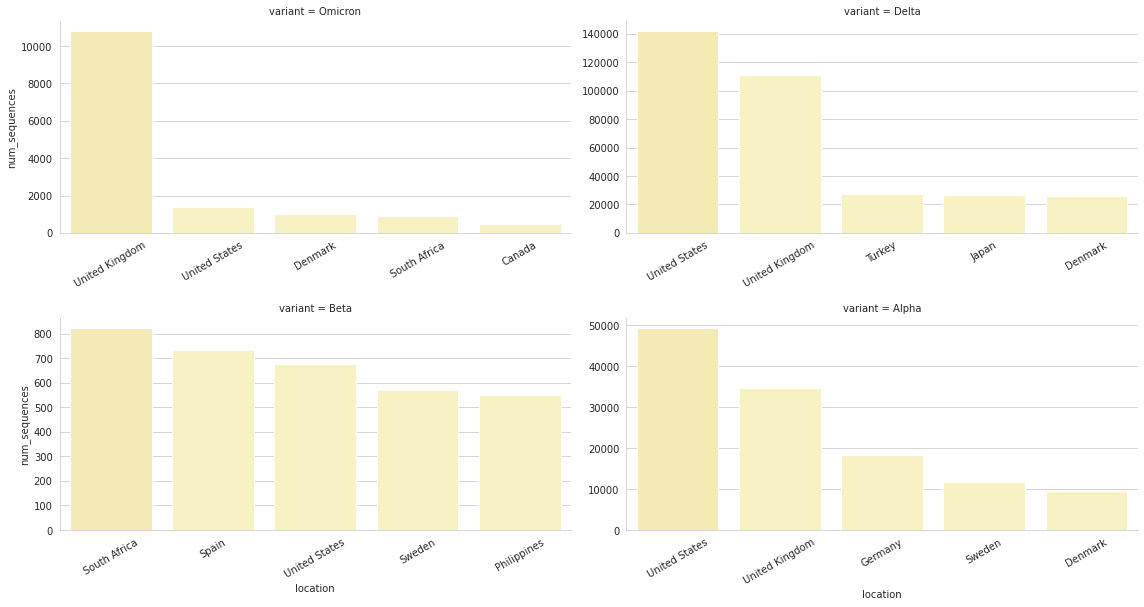

In [ ]:
import seaborn as sns

df = most_inflected_5_countries
y = most_inflected_5_countries['num_sequences']
# sns.set_color_codes("muted")
g = sns.FacetGrid(df, col='variant', sharex=False, sharey=False, col_wrap=2, height=4, aspect=2)
g.map_dataframe(sns.barplot, x='location', y='num_sequences' ,palette=colors_from_values(y, "YlOrRd"))
# set rotation
g.set_xticklabels(rotation=30)
plt.subplots_adjust(hspace = 0.4)



### **New cases vs deaths and percentage of vaccinated population of selected countries**


We will be selecting some of the countries in the following conditions and compare the total confirmed cases and deaths:

- Mainly uses mRNA vaccines -- US

- Mainly uses viral vector and/or inactivated vaccines -- Venezuela

- Mix -- Germany

- Lowest % of people vaccination -- Haiti




> ### **US**



In [ ]:
covid_cases_owid_US = covid_cases_owid.loc[covid_cases_owid['location']=='United States']


covid_cases_owid_US['new_cases_%'] = (covid_cases_owid_US['new_cases']/covid_cases_owid_US['population'])*100

covid_cases_owid_US = covid_cases_owid_US[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

 
covid_cases_owid_US.head()

date  ...  new_deaths_smoothed_per_million
153489  2020-01-22  ...                              0.0
153490  2020-01-23  ...                              0.0
153491  2020-01-24  ...                              0.0
153492  2020-01-25  ...                              0.0
153493  2020-01-26  ...                              0.0

[5 rows x 12 columns]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=covid_cases_owid_US['date'], y = covid_cases_owid_US['new_cases_per_million'], mode='lines',name='new_cases_permil'))
fig.add_trace(go.Scatter(x=covid_cases_owid_US['date'], y = covid_cases_owid_US['new_deaths_per_million'], mode='lines',name='new_deaths_permil'))

fig.add_trace(go.Scatter(x=covid_cases_owid_US['date'], y = covid_cases_owid_US['new_cases_smoothed_per_million'], mode='lines',line=dict(color="#3268F9"),fill='tozeroy',fillcolor='rgba(41, 104, 213, 0.68)', name='new cases/million in avg'))
fig.add_trace(go.Scatter(x=covid_cases_owid_US['date'], y = covid_cases_owid_US['new_deaths_smoothed_per_million'], mode='lines',line=dict(color="#EA4504"),fill='tozeroy',fillcolor='rgba(255, 129, 74, 0.71)', name='avg_new_deaths_permil'))


fig.add_trace(go.Scatter(x=covid_cases_owid_US['date'], y = covid_cases_owid_US['total_deaths'], mode='lines',name='total_deaths'))
fig.add_trace(go.Scatter(x=covid_cases_owid_US['date'], y = covid_cases_owid_US['total_cases'], mode='lines',name='total_cases'))


fig.update_layout(title_text='New Confirmed, Total Confirmed Cases, New Deaths and Total Deaths in the U.S.',plot_bgcolor='rgb(230, 230, 230)',font=dict(
        size=12), xaxis_rangeslider_visible=True,title_x=0.5)
fig.update_yaxes(type="log", title_text = "Log y (cases)")

fig.show()

> ### **Venezuela**


In [ ]:
covid_cases_owid_VEN = covid_cases_owid.loc[covid_cases_owid['location']=='Venezuela']

covid_cases_owid_VEN['new_cases_%'] = (covid_cases_owid_VEN['new_cases']/covid_cases_owid_VEN['population'])*100

covid_cases_owid_VEN = covid_cases_owid_VEN[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

covid_cases_owid_VEN

date  ...  new_deaths_smoothed_per_million
157590  2020-03-14  ...                            0.000
157591  2020-03-15  ...                            0.000
157592  2020-03-16  ...                            0.000
157593  2020-03-17  ...                            0.000
157594  2020-03-18  ...                            0.000
...            ...  ...                              ...
158290  2022-02-12  ...                            0.239
158291  2022-02-13  ...                            0.254
158292  2022-02-14  ...                            0.309
158293  2022-02-15  ...                            0.304
158294  2022-02-16  ...                            0.299

[705 rows x 12 columns]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=covid_cases_owid_VEN['date'], y = covid_cases_owid_VEN['new_cases_per_million'], mode='lines',name='new_cases_permil'))
fig.add_trace(go.Scatter(x=covid_cases_owid_VEN['date'], y = covid_cases_owid_VEN['new_deaths_per_million'], mode='lines',name='new_deaths_permil'))



fig.add_trace(go.Scatter(x=covid_cases_owid_VEN['date'], y = covid_cases_owid_VEN['new_cases_smoothed_per_million'], mode='lines',line=dict(color="#3268F9"),fill='tozeroy',fillcolor='rgba(41, 104, 213, 0.68)', name='avg_new_cases_permil'))
fig.add_trace(go.Scatter(x=covid_cases_owid_VEN['date'], y = covid_cases_owid_VEN['new_deaths_smoothed_per_million'], mode='lines',line=dict(color="#EA4504"),fill='tozeroy',fillcolor='rgba(255, 129, 74, 0.71)', name='avg_new_deaths_permil'))


fig.add_trace(go.Scatter(x=covid_cases_owid_VEN['date'], y = covid_cases_owid_VEN['total_deaths'], mode='lines',name='total_deaths'))
fig.add_trace(go.Scatter(x=covid_cases_owid_VEN['date'], y = covid_cases_owid_VEN['total_cases'], mode='lines',name='total_cases'))


fig.update_layout(title_text='New Confirmed, Total Confirmed Cases, New Deaths and Total Deaths in Venezuela',plot_bgcolor='rgb(230, 230, 230)',font=dict(
        size=12), xaxis_rangeslider_visible=True,title_x=0.5)
fig.update_yaxes(type="log", title_text = "Log y (cases)")

fig.show()

> ### **Germany**

In [ ]:
covid_cases_owid_GE = covid_cases_owid.loc[covid_cases_owid['location']=='Germany']


covid_cases_owid_GE['new_cases_%'] = (covid_cases_owid_GE['new_cases']/covid_cases_owid_GE['population'])*100

covid_cases_owid_GE = covid_cases_owid_GE[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

 
covid_cases_owid_GE.head()

date  ...  new_deaths_smoothed_per_million
56141  2020-01-27  ...                              0.0
56142  2020-01-28  ...                              0.0
56143  2020-01-29  ...                              0.0
56144  2020-01-30  ...                              0.0
56145  2020-01-31  ...                              0.0

[5 rows x 13 columns]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=covid_cases_owid_GE['date'], y = covid_cases_owid_GE['new_cases_per_million'], mode='lines',name='new_cases_permil'))
fig.add_trace(go.Scatter(x=covid_cases_owid_GE['date'], y = covid_cases_owid_GE['new_deaths_per_million'], mode='lines',name='new_deaths_permil'))

fig.add_trace(go.Scatter(x=covid_cases_owid_GE['date'], y = covid_cases_owid_GE['new_cases_smoothed_per_million'], mode='lines',line=dict(color="#3268F9"),fill='tozeroy',fillcolor='rgba(41, 104, 213, 0.68)', name='new cases/million in avg'))
fig.add_trace(go.Scatter(x=covid_cases_owid_GE['date'], y = covid_cases_owid_GE['new_deaths_smoothed_per_million'], mode='lines',line=dict(color="#EA4504"),fill='tozeroy',fillcolor='rgba(255, 129, 74, 0.71)', name='avg_new_deaths_permil'))


fig.add_trace(go.Scatter(x=covid_cases_owid_GE['date'], y = covid_cases_owid_GE['total_deaths'], mode='lines',name='total_deaths'))
fig.add_trace(go.Scatter(x=covid_cases_owid_GE['date'], y = covid_cases_owid_GE['total_cases'], mode='lines',name='total_cases'))


fig.update_layout(title_text='New Confirmed, Total Confirmed Cases, New Deaths and Total Deaths in Germany',plot_bgcolor='rgb(230, 230, 230)',font=dict(
        size=12), xaxis_rangeslider_visible=True,title_x=0.5)
fig.update_yaxes(type="log", title_text = "Log y (cases)")

fig.show()

> ### **Haiti**

In [ ]:
covid_cases_owid_HAT = covid_cases_owid.loc[covid_cases_owid['location']=='Haiti']
covid_cases_owid_HAT['new_cases_%'] = (covid_cases_owid_HAT['new_cases']/covid_cases_owid_HAT['population'])*100

covid_cases_owid_HAT = covid_cases_owid_HAT[['date','new_cases','new_deaths','new_cases_%', 'total_cases','total_deaths','population','new_cases_smoothed','new_cases_per_million','new_deaths_per_million','new_cases_smoothed_per_million','new_deaths_smoothed_per_million']]

covid_cases_owid_HAT

date  ...  new_deaths_smoothed_per_million
63664  2020-03-20  ...                            0.000
63665  2020-03-21  ...                            0.000
63666  2020-03-22  ...                            0.000
63667  2020-03-23  ...                            0.000
63668  2020-03-24  ...                            0.000
...           ...  ...                              ...
64358  2022-02-12  ...                            0.037
64359  2022-02-13  ...                            0.037
64360  2022-02-14  ...                            0.037
64361  2022-02-15  ...                            0.037
64362  2022-02-16  ...                            0.037

[699 rows x 12 columns]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=covid_cases_owid_HAT['date'], y = covid_cases_owid_HAT['new_cases_per_million'], mode='lines',name='new_cases_permil'))
fig.add_trace(go.Scatter(x=covid_cases_owid_HAT['date'], y = covid_cases_owid_HAT['new_deaths_per_million'], mode='lines',name='new_deaths_permil'))



fig.add_trace(go.Scatter(x=covid_cases_owid_HAT['date'], y = covid_cases_owid_HAT['new_cases_smoothed_per_million'], mode='lines',line=dict(color="#3268F9"),fill='tozeroy',fillcolor='rgba(41, 104, 213, 0.68)', name='avg_new_cases_permil'))
fig.add_trace(go.Scatter(x=covid_cases_owid_HAT['date'], y = covid_cases_owid_HAT['new_deaths_smoothed_per_million'], mode='lines',line=dict(color="#EA4504"),fill='tozeroy',fillcolor='rgba(255, 129, 74, 0.71)', name='avg_new_deaths_permil'))


fig.add_trace(go.Scatter(x=covid_cases_owid_HAT['date'], y = covid_cases_owid_HAT['total_deaths'], mode='lines',name='total_deaths'))
fig.add_trace(go.Scatter(x=covid_cases_owid_HAT['date'], y = covid_cases_owid_HAT['total_cases'], mode='lines',name='total_cases'))


fig.update_layout(title_text='New Confirmed, Total Confirmed Cases, New Deaths and Total Deaths in Haiti',plot_bgcolor='rgb(230, 230, 230)',font=dict(
        size=12), xaxis_rangeslider_visible=True,title_x=0.5)
fig.update_yaxes(type="log", title_text = "Log y (cases)")

fig.show()

In [ ]:
countries = ['United States', 'Germany','Venezuela','Haiti']


In [ ]:
def plot_time_variation_countries_group(DF_name, feature, title, countries):
    data = []
    for country in countries:
        df = covid_cases_owid.loc[covid_cases_owid.location==country]
        trace = go.Scatter(
            x = df['date'],y = df[feature],
            name=country,
            mode = "markers+lines",
            marker_line_width = 0.5,
            marker_size = 8,
            marker_symbol = 'circle',
            text=df['location'])
        data.append(trace)
    layout = dict(title = title,title_x=0.5,
          xaxis = dict(title = 'Date', showticklabels=True,zeroline=True, zerolinewidth=1, zerolinecolor='grey',
                       showline=True, linewidth=2, linecolor='black', mirror=True,
                       tickfont=dict(size=10,color='darkblue'),), 
          yaxis = dict(title = feature, gridcolor='lightgrey', zeroline=True, zerolinewidth=1, zerolinecolor='grey',
                       showline=True, linewidth=2, linecolor='black', mirror=True, type="log"),
                       plot_bgcolor = 'rgba(0, 0, 0, 0)', paper_bgcolor = 'rgba(0, 0, 0, 0)',
         hovermode = 'x', 
         height=800
         )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='all_countries')

In [ ]:
 plot_time_variation_countries_group(covid_cases_owid, 'new_cases_smoothed_per_million', 'Avg new cases per million evolution (selected countries, log scale)', countries)

In [ ]:
 plot_time_variation_countries_group(covid_cases_owid, 'new_deaths_smoothed_per_million', 'Avg new deaths per million evolution (selected countries, log scale)', countries)

In [ ]:
 plot_time_variation_countries_group(covid_cases_owid, 'total_cases', 'Total cases (selected countries, log scale)', countries)

In [ ]:
 plot_time_variation_countries_group(covid_cases_owid, 'total_deaths', 'Total deaths (selected countries, log scale)', countries)

# Prediction

We will predict the total new cases and deaths trend  
To know how effective the vaccine types are, we will look at the daily cases and death rates and 

In [ ]:
# convert an array of values into a dataset matrix and split the data
#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).
# convert an array of values into a dataset matrix
# X		Y
# 112		148
# 119		132
# can see the X=t and Y=t+1 pattern

# and

# split the X and y in such a way that X will contain cases for a certain amount of 
# previous days 
# and y contains the reading for the next day.

# Time steps: seq_size or T or previous = look_back 
# create this formulation of the time series problem by increasing the look_back argument from 1 to p

# A “lookback period” defines how many previous timesteps are used in order to 
# predict the subsequent timestep. In this regard, we are using a one-step prediction model.
# The lookback period is set to 5 in this instance. 
# This means that we are using the time steps at t-4, t-3, t-2, t-1, and t to predict the value at time t+1.
def create_dataset(df,previous,split_ratio):
    X, Y = [], []
    for i in range(len(df)-previous):
        a = df[i:(i+previous)]
        X.append(a)
        y = df[i+previous]
        Y.append(y)
    X = np.array(X).reshape(-1,T,1)
    Y = np.array(Y)
    N = len(X)
    split = round(split_ratio*len(df)) 
    X_train = X[:split]
    X_test = X[split:]
    Y_train = Y[:split]
    Y_test = Y[split:]
    print("X.shape", X.shape, "Y.shape", Y.shape)
    print("X_train.shape", X_train.shape, "Y_train.shape", Y_train.shape)
    print("X_test.shape", X_test.shape, "Y_test.shape", Y_test.shape)
    return X,X_train,X_test,Y,Y_train,Y_test

In [ ]:
#Building the model architecture
# Plot validation loss vs training loss to see how “good” or “bad” 
# a given predictor is at classifying the input data.
def plotLearningCurve(history,epochnum,batchnum):
  epochRange = range(1,epochnum+1)
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  plt.plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  plt.xlabel('Epoch', fontsize = 15)
  plt.ylabel('Loss', fontsize = 15)
  plt.grid(color='gray', linestyle='--')
  plt.legend()
  plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
  plt.show()


#### US

In [ ]:
df_total_cases_US = covid_cases_owid_US[['date','total_cases']]

df_total_cases_US.head()

date  total_cases
153489  2020-01-22          1.0
153490  2020-01-23          1.0
153491  2020-01-24          2.0
153492  2020-01-25          2.0
153493  2020-01-26          5.0

In [ ]:
df_total_cases_US.dtypes

date            object
total_cases    float64
dtype: object

In [ ]:
dataset = df_total_cases_US.iloc[:,1].values #using only confirmed cases
dataset.shape

(757,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset))   #train_size
dataset = dataset.reshape(-1,1)
#perform a robust scaler transform of the dataset
scaler = MinMaxScaler(feature_range=(0,1))
# Fit the scaler using available training data. 
# For normalization, this means the training data will be used to estimate 
# the minimum and maximum observable values. This is done by calling the fit() function.
scaler.fit(dataset[:split]) #fit only on the training data which is the first 80%
# Apply the scale to training data. 
# This means you can use the normalized data to train your model.
#  This is done by calling the transform() function.
# Apply the scale to data going forward. 
# This means you can prepare new data in the future on which you want to make predictions.
dataset_n = scaler.transform(dataset).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_n.shape


(757,)

In [ ]:
T = seq_size = 5  #number of past days used to predict the value for the current day
X,X_train,X_test,Y,Y_train,Y_test = create_dataset(dataset_n,T,0.8) #80% of data for training and 20% for testing

X.shape (752, 5, 1) Y.shape (752,)
X_train.shape (606, 5, 1) Y_train.shape (606,)
X_test.shape (146, 5, 1) Y_test.shape (146,)


In [ ]:
best_size = Y_test
# train_score = X_train
# train_list.append(train_score)


test_start = len(covid_cases_owid_US.date)-len(best_size)
test_start

611

In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_size,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
model.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_10 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r = model.fit(X_train,
                    Y_train,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction])

Epoch 1/100
8/8 [==============================] - 6s 116ms/step - loss: 0.1472 - val_loss: 0.6440 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.1212 - val_loss: 0.5450 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0911 - val_loss: 0.4152 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0598 - val_loss: 0.2551 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0330 - val_loss: 0.1017 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0249 - val_loss: 0.0181 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0258 - val_loss: 0.0053 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0179 - val_loss: 0.0065 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0078 - val_loss: 1.9932e-04 - lr: 0.0

In [ ]:
n_epochs = len(r.history['loss'])

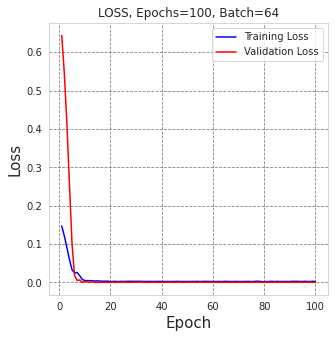

In [ ]:
plotLearningCurve(r,epochnum,batchnum)

In [ ]:
print("Train score:", model.evaluate(X_train,Y_train))
print("Test score:", model.evaluate(X_test,Y_test))


19/19 [==============================] - 0s 4ms/step - loss: 1.7166e-04
Train score: 0.00017166287580039352
5/5 [==============================] - 0s 5ms/step - loss: 0.0164
Test score: 0.016355356201529503


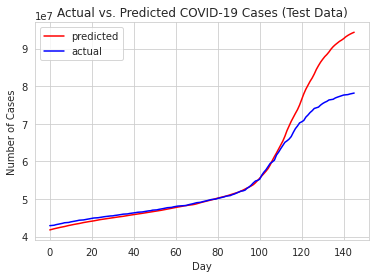

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred = model.predict(X_test)

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred = scaler.inverse_transform(Y_pred)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))
Y_train = scaler.inverse_transform(Y_train.reshape(-1,1))

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred, color='red')
plt.plot(Y_test, color='blue')
plt.title('Actual vs. Predicted COVID-19 Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)
Y_pred = Y_pred.reshape(-1)

date_array = np.array(df_total_cases_US['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1US = go.Scatter(
    x = date_train,
    y = Y_train,
    mode = 'lines',
    name = 'Data_US'
)
trace2US = go.Scatter(
    x = date_test,
    y = Y_pred,
    mode = 'lines',
    name = 'Prediction_US'
)
trace3US = go.Scatter(
    x = date_test,
    y = Y_test,
    mode='lines',
    name = 'Ground Truth_US'
)
layout = go.Layout(
    title = "<b>U.S. Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace1US, trace2US, trace3US], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid cases to see the overall accuracy of the model

T = seq_size = 5 
prediction_list = dataset_n[-T:]  #take last 10 values from the dataset
num_prediction = 16 #predicting cases for next 16 days
for _ in range(num_prediction):
    x = prediction_list[-T:]
    x = x.reshape((1,T, 1))
    out = model.predict(x)[0][0]
    prediction_list = np.append(prediction_list, out) #appending the prediction
prediction_list = prediction_list[T-1:] 
prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1,1)).reshape(-1)


last_date = df_total_cases_US['date'].values[-1]
prediction_dates = np.array(pd.date_range(last_date, periods=num_prediction))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates)


In [ ]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

In [ ]:
prediction_dates_O.dtype

dtype('<M8[ns]')

In [ ]:
trace1_US = go.Scatter(
    x = date_array,
    y = dataset.reshape(-1),
    mode = 'lines',
    name = 'Data_US'
)

trace2_US = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list,
    mode = 'lines',
    name = 'Forecast_US'
)
layout = go.Layout(
    title = "<b>U.S. Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}

)


fig = go.Figure(data=[trace1_US, trace2_US], layout=layout)
fig.show()

In [ ]:
[prediction_dates_O,prediction_list] 

[DatetimeIndex(['2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19',
                '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
                '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27',
                '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03'],
               dtype='datetime64[ns]', freq=None),
 array([7.81728400e+07, 9.45313815e+07, 9.71827481e+07, 1.02802657e+08,
        1.12539321e+08, 1.28714736e+08, 1.56196834e+08, 1.86325035e+08,
        2.46577219e+08, 3.80274378e+08, 7.31904956e+08, 1.55549704e+09,
        3.43572504e+09, 8.07393748e+09, 1.93232361e+10, 4.80759680e+10,
        1.17280210e+11])]

### Venezuela

In [ ]:
df_total_cases_VEN = covid_cases_owid_VEN[['date','total_cases']]

df_total_cases_VEN#.head()


date  total_cases
157590  2020-03-14          2.0
157591  2020-03-15         10.0
157592  2020-03-16         17.0
157593  2020-03-17         33.0
157594  2020-03-18         36.0
...            ...          ...
158290  2022-02-12     503162.0
158291  2022-02-13     504719.0
158292  2022-02-14     505947.0
158293  2022-02-15     506977.0
158294  2022-02-16     508042.0

[705 rows x 2 columns]

In [ ]:

dataset_VEN = df_total_cases_VEN.iloc[:,1].values #using only confirmed cases
dataset_VEN.shape

(705,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset_VEN))   #train_size
dataset_VEN = dataset_VEN.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataset_VEN[:split]) #fit only on the training data which is the first 80%
dataset_VEN_n = scaler.transform(dataset_VEN).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_VEN_n.shape


(705,)

In [ ]:
# T = seq_size = 10  #number of past days used to predict the value for the current day
X_VEN,X_train_VEN,X_test_VEN,Y_VEN,Y_train_VEN,Y_test_VEN = create_dataset(dataset_VEN_n,T,0.8) #80% of data for training and 20% for testing

X.shape (700, 5, 1) Y.shape (700,)
X_train.shape (564, 5, 1) Y_train.shape (564,)
X_test.shape (136, 5, 1) Y_test.shape (136,)


In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

model_VEN = Sequential()
model_VEN.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(T,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
model_VEN.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model_VEN.add(LSTM(64, activation='relu'))
model_VEN.add(Dropout(0.2))
model_VEN.add(Dense(1, activation='relu'))
model_VEN.compile(optimizer='adam', loss='mean_squared_error')

model_VEN.summary()
print('Train...')


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_12 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction_VEN = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop_VEN = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r_VEN = model_VEN.fit(X_train_VEN,
                    Y_train_VEN,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction_VEN])

Epoch 1/100
8/8 [==============================] - 9s 437ms/step - loss: 0.0896 - val_loss: 0.6726 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0676 - val_loss: 0.5474 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0446 - val_loss: 0.4010 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0259 - val_loss: 0.2438 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0187 - val_loss: 0.1168 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0239 - val_loss: 0.0604 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0236 - val_loss: 0.0456 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0167 - val_loss: 0.0387 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0206 - lr: 0.0010


In [ ]:
n_epochs_VEN = len(r_VEN.history['loss'])

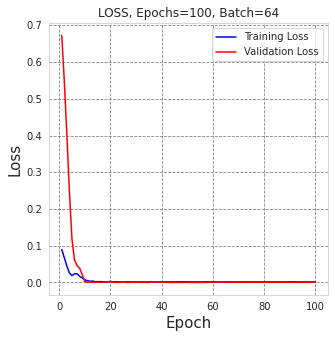

In [ ]:
plotLearningCurve(r_VEN,epochnum,batchnum)

In [ ]:
print("Train score:", model_VEN.evaluate(X_train_VEN,Y_train_VEN))
print("Test score:", model_VEN.evaluate(X_test_VEN,Y_test_VEN))


18/18 [==============================] - 0s 4ms/step - loss: 1.3022e-04
Train score: 0.00013021592167206109
5/5 [==============================] - 0s 5ms/step - loss: 0.0024
Test score: 0.002387487795203924


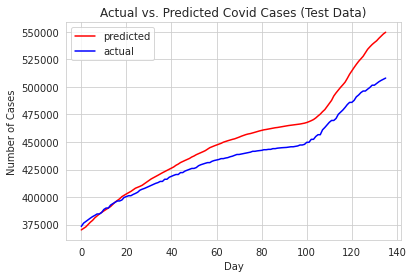

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred_VEN = model_VEN.predict(X_test_VEN)

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred_VEN = scaler.inverse_transform(Y_pred_VEN)
Y_test_VEN = scaler.inverse_transform(Y_test_VEN.reshape(-1,1))
Y_train_VEN = scaler.inverse_transform(Y_train_VEN.reshape(-1,1))

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred_VEN, color='red')
plt.plot(Y_test_VEN, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train_VEN = Y_train_VEN.reshape(-1)
Y_test_VEN = Y_test_VEN.reshape(-1)
Y_pred_VEN = Y_pred_VEN.reshape(-1)

date_array = np.array(df_total_cases_VEN['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1VEN = go.Scatter(
    x = date_train,
    y = Y_train_VEN,
    mode = 'lines',
    name = 'Data_VEN'
)
trace2VEN = go.Scatter(
    x = date_test,
    y = Y_pred_VEN,
    mode = 'lines',
    name = 'Prediction_VEN'
)
trace3VEN = go.Scatter(
    x = date_test,
    y = Y_test_VEN,
    mode='lines',
    name = 'Ground Truth_VEN'
)
layout = go.Layout(
    title = "<b>Venezuala Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace1VEN, trace2VEN, trace3VEN], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid cases to see the overall accuracy of the model

# T = seq_size = 10 
prediction_list_VEN = dataset_VEN_n[-T:]  #take last 10 values from the dataset
num_prediction = 16 #predicting cases for next 16 days
for _ in range(num_prediction):
    x = prediction_list_VEN[-T:]
    x = x.reshape((1,T, 1))
    out = model_VEN.predict(x)[0][0]
    prediction_list_VEN = np.append(prediction_list_VEN, out) #appending the prediction
prediction_list_VEN = prediction_list_VEN[T-1:] 
prediction_list_VEN = scaler.inverse_transform(np.array(prediction_list_VEN).reshape(-1,1)).reshape(-1)


last_date_VEN = df_total_cases_VEN['date'].values[-1]
prediction_dates_VEN = np.array(pd.date_range(last_date_VEN, periods=num_prediction))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates_VEN)


In [ ]:
trace1_VEN = go.Scatter(
    x = date_array,
    y = dataset_VEN.reshape(-1),
    mode = 'lines',
    name = 'Data_VEN'
)

trace2_VEN = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list_VEN,
    mode = 'lines',
    name = 'Forecast_VEN'
)
layout = go.Layout(
    title = "<b>Venezuala Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace1_VEN, trace2_VEN], layout=layout)
fig.show()

### Germany

In [ ]:
df_total_cases_GE = covid_cases_owid_GE[['date','total_cases']]

df_total_cases_GE.head()

date  total_cases
56141  2020-01-27          1.0
56142  2020-01-28          4.0
56143  2020-01-29          4.0
56144  2020-01-30          4.0
56145  2020-01-31          5.0

In [ ]:
dataset_GE = df_total_cases_GE.iloc[:,1].values #using only confirmed cases
dataset_GE.shape

(752,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset_GE))   #train_size
dataset_GE = dataset_GE.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataset_GE[:split]) #fit only on the training data which is the first 80%
dataset_GE_n = scaler.transform(dataset_GE).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_GE_n.shape


(752,)

In [ ]:
# T = seq_size = 10  #number of past days used to predict the value for the current day
X_GE,X_train_GE,X_test_GE,Y_GE,Y_train_GE,Y_test_GE = create_dataset(dataset_GE_n,T,0.8) #80% of data for training and 20% for testing

X.shape (747, 5, 1) Y.shape (747,)
X_train.shape (602, 5, 1) Y_train.shape (602,)
X_test.shape (145, 5, 1) Y_test.shape (145,)


In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

model_GE = Sequential()
model_GE.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(T,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
model_GE.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model_GE.add(LSTM(64, activation='relu'))
model_GE.add(Dropout(0.2))
model_GE.add(Dense(1, activation='relu'))
model_GE.compile(optimizer='adam', loss='mean_squared_error')

model_GE.summary()
print('Train...')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_14 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction_GE = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r_GE = model_GE.fit(X_train_GE,
                    Y_train_GE,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction_GE])

Epoch 1/100
8/8 [==============================] - 6s 108ms/step - loss: 0.1278 - val_loss: 0.7283 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1053 - val_loss: 0.6203 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0817 - val_loss: 0.4826 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0560 - val_loss: 0.3162 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0344 - val_loss: 0.1498 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0279 - val_loss: 0.0410 - lr: 0.0010
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0254 - val_loss: 0.0089 - lr: 0.0010
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0168 - val_loss: 0.0094 - lr: 0.0010
Epoch 9/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0077 - val_loss: 8.3868e-04 - lr: 0.0

In [ ]:
n_epochs_GE = len(r_GE.history['loss'])

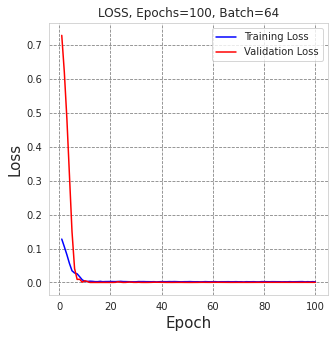

In [ ]:
plotLearningCurve(r_GE,epochnum,batchnum)

In [ ]:
print("Train score:", model_GE.evaluate(X_train_GE,Y_train_GE))
print("Test score:", model_GE.evaluate(X_test_GE,Y_test_GE))


19/19 [==============================] - 0s 5ms/step - loss: 1.6075e-04
Train score: 0.00016074696031864733
5/5 [==============================] - 0s 4ms/step - loss: 0.2778
Test score: 0.2778269648551941


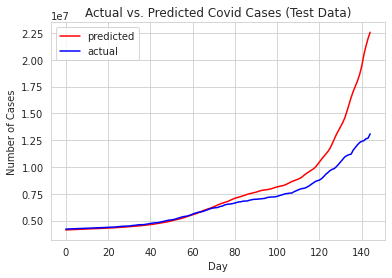

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred_GE = model_GE.predict(X_test_GE)

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred_GE = scaler.inverse_transform(Y_pred_GE)
Y_test_GE = scaler.inverse_transform(Y_test_GE.reshape(-1,1))
Y_train_GE = scaler.inverse_transform(Y_train_GE.reshape(-1,1))

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred_GE, color='red')
plt.plot(Y_test_GE, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train_GE = Y_train_GE.reshape(-1)
Y_test_GE = Y_test_GE.reshape(-1)
Y_pred_GE = Y_pred_GE.reshape(-1)

date_array = np.array(df_total_cases_GE['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1GE = go.Scatter(
    x = date_train,
    y = Y_train_GE,
    mode = 'lines',
    name = 'Data_GE'
)
trace2GE = go.Scatter(
    x = date_test,
    y = Y_pred_GE,
    mode = 'lines',
    name = 'Prediction_GE'
)
trace3GE = go.Scatter(
    x = date_test,
    y = Y_test_GE,
    mode='lines',
    name = 'Ground Truth_GE'
)
layout = go.Layout(
    title = "<b>Germany Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace1GE, trace2GE, trace3GE], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid cases to see the overall accuracy of the model

# T = seq_size = 10 
prediction_list_GE = dataset_GE_n[-T:]  #take last 10 values from the dataset
num_prediction = 16 #predicting cases for next 16 days
for _ in range(num_prediction):
    x = prediction_list_GE[-T:]
    x = x.reshape((1,T, 1))
    out = model_GE.predict(x)[0][0]
    prediction_list_GE = np.append(prediction_list_GE, out) #appending the prediction
prediction_list_GE = prediction_list_GE[T-1:] 
prediction_list_GE = scaler.inverse_transform(np.array(prediction_list_GE).reshape(-1,1)).reshape(-1)


last_date_GE = df_total_cases_GE['date'].values[-1]
prediction_dates_GE = np.array(pd.date_range(last_date_GE, periods=num_prediction))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates_GE)


In [ ]:
trace1_GE = go.Scatter(
    x = date_array,
    y = dataset_GE.reshape(-1),
    mode = 'lines',
    name = 'Data_GE'
)

trace2_GE = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list_GE,
    mode = 'lines',
    name = 'Forecast_GE'
)

layout = go.Layout(
    title = "<b>Germany Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace1_GE, trace2_GE], layout=layout)
fig.show()

### Haiti

In [ ]:
df_total_cases_HAT = covid_cases_owid_HAT[['date','total_cases']]

df_total_cases_HAT.head()

date  total_cases
63664  2020-03-20          2.0
63665  2020-03-21          2.0
63666  2020-03-22          2.0
63667  2020-03-23          2.0
63668  2020-03-24          7.0

In [ ]:
dataset_HAT = df_total_cases_HAT.iloc[:,1].values #using only confirmed cases
dataset_HAT.shape

(699,)

In [ ]:
#Feature scaling
split = round(0.8*len(dataset_HAT))   #train_size
dataset_HAT = dataset_HAT.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dataset_HAT[:split]) #fit only on the training data which is the first 80%
dataset_HAT_n = scaler.transform(dataset_HAT).flatten() #flatten doesnt make big diff (727,) vs (727,1) changes the shape of a Numpy array from a multi-dimensional array, to a 1-dimensional array.
dataset_HAT_n.shape


(699,)

In [ ]:
# T = seq_size = 10  #number of past days used to predict the value for the current day
X_HAT,X_train_HAT,X_test_HAT,Y_HAT,Y_train_HAT,Y_test_HAT = create_dataset(dataset_HAT_n,T,0.8) #80% of data for training and 20% for testing

X.shape (694, 5, 1) Y.shape (694,)
X_train.shape (559, 5, 1) Y_train.shape (559,)
X_test.shape (135, 5, 1) Y_test.shape (135,)


In [ ]:
# Building the model architecture

# #Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

model_HAT = Sequential()
model_HAT.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(T,1))) # removed #features because when compile model get...ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(None, 7, 1)
model_HAT.add(Dropout(0.4)) #regularization to improve validation/testing accuracy 
model_HAT.add(LSTM(64, activation='relu'))
model_HAT.add(Dropout(0.2))
model_HAT.add(Dense(1, activation='relu'))
model_HAT.compile(optimizer='adam', loss='mean_squared_error')

model_HAT.summary()
print('Train...')


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_16 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Train...


In [ ]:
#To lower the learning rate of a model when a metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates
batchnum = 64
epochnum = 100
learning_rate_reduction_HAT = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
early_stop = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)
r_HAT = model_HAT.fit(X_train_HAT,
                    Y_train_HAT,
                    batch_size=batchnum,
                    epochs=epochnum,
                    validation_split=0.2,
                    shuffle=False, #time_series
                    callbacks=[learning_rate_reduction_HAT])

Epoch 1/100
7/7 [==============================] - 6s 117ms/step - loss: 0.1724 - val_loss: 0.7401 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 0.1322 - val_loss: 0.5998 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0865 - val_loss: 0.4168 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0392 - val_loss: 0.2064 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0126 - val_loss: 0.0545 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0209 - val_loss: 0.0307 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0216 - val_loss: 0.0640 - lr: 0.0010
Epoch 8/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0159 - val_loss: 0.0754 - lr: 0.0010
Epoch 9/100
7/7 [==============================] - ETA: 0s - loss: 0.0124
Epoch 9: ReduceLROnPlateau reducing l

In [ ]:
n_epochs_HAT = len(r_HAT.history['loss'])

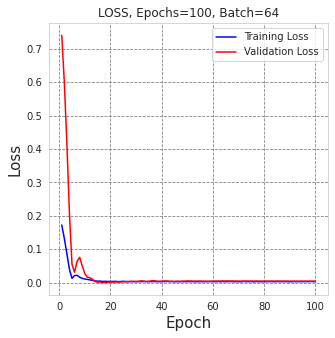

In [ ]:
plotLearningCurve(r_HAT,epochnum,batchnum)

In [ ]:
# Model Accuracy: using built-in model evaluation (based on the loss function) to generate evaluation scores

print("Train score:", model_HAT.evaluate(X_train_HAT,Y_train_HAT))
print("Test score:", model_HAT.evaluate(X_test_HAT,Y_test_HAT))


18/18 [==============================] - 0s 4ms/step - loss: 9.7445e-04
Train score: 0.0009744521230459213
5/5 [==============================] - 0s 5ms/step - loss: 0.0050
Test score: 0.005007295869290829


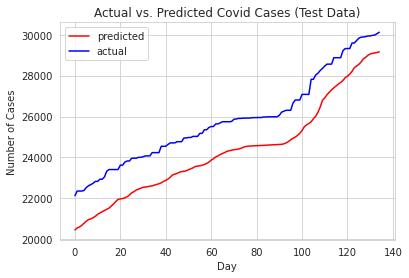

In [ ]:
# Predicting test data
# Plotting the Prediction


# generate the next predictions
Y_pred_HAT = model_HAT.predict(X_test_HAT) #testPredict

# invert predictions
# transform the forecasts back to the original scale
# To accurately plot the values we need to bring the prediction and y_test data 
# back to the original bounds of the data.
Y_pred_HAT = scaler.inverse_transform(Y_pred_HAT) #testPredict
Y_test_HAT= scaler.inverse_transform(Y_test_HAT.reshape(-1,1)) #testPredict
Y_train_HAT = scaler.inverse_transform(Y_train_HAT.reshape(-1,1)) #trainY

# plot a graph between the actual Covid cases vs predicted Covid cases to see the overall accuracy of the model
plt.plot(Y_pred_HAT, color='red')
plt.plot(Y_test_HAT, color='blue')
plt.title('Actual vs. Predicted Covid Cases (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])



In [ ]:
# Forecasting future values

Y_train_HAT = Y_train_HAT.reshape(-1)
Y_test_HAT = Y_test_HAT.reshape(-1)
Y_pred_HAT = Y_pred_HAT.reshape(-1)

date_array = np.array(df_total_cases_HAT['date'].values)
date_train = date_array[:split]
date_test = date_array[split:]


In [ ]:
# In order to see the prediction and see the accuracy, 
# first, we will predict the output of our X_test data. 
# This is the output that we get from the test data.
# Y_train, Y_pred, Y_test


trace1HAT = go.Scatter(
    x = date_train,
    y = Y_train_HAT,
    mode = 'lines',
    name = 'Data_HAT'
)
trace2HAT = go.Scatter(
    x = date_test,
    y = Y_pred_HAT,
    mode = 'lines',
    name = 'Prediction_HAT'
)
trace3HAT = go.Scatter(
    x = date_test,
    y = Y_test_HAT,
    mode='lines',
    name = 'Ground Truth_HAT'
)
layout = go.Layout(
    title = "<b>Haiti Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace1HAT, trace2HAT, trace3HAT], layout=layout)
fig.show()

In [ ]:
# Now, plot a graph between the actual vs predicted Covid cases to see the overall accuracy of the model

# T = seq_size = 10 
prediction_list_HAT = dataset_HAT_n[-T:]  #take last 10 values from the dataset
num_prediction = 16 #predicting cases for next 16 days
for _ in range(num_prediction):
    x = prediction_list_HAT[-T:]
    x = x.reshape((1,T, 1))
    out = model_HAT.predict(x)[0][0]
    prediction_list_HAT = np.append(prediction_list_HAT, out) #appending the prediction
prediction_list_HAT = prediction_list_HAT[T-1:] 
prediction_list_HAT = scaler.inverse_transform(np.array(prediction_list_HAT).reshape(-1,1)).reshape(-1)


last_date_HAT = df_total_cases_HAT['date'].values[-1]
prediction_dates_HAT = np.array(pd.date_range(last_date_HAT, periods=num_prediction))

#Change dateandtime format from '2022-01-17T00:00:00.000000000' to 2015-02-04 (type:datetime64[ns])
prediction_dates_O = pd.to_datetime(prediction_dates_HAT)


In [ ]:
trace1_HAT = go.Scatter(
    x = date_array,
    y = dataset_HAT.reshape(-1),
    mode = 'lines',
    name = 'Data_HAT'
)

trace2_HAT = go.Scatter(
    x = prediction_dates_O,
    y = prediction_list_HAT,
    mode = 'lines',
    name = 'Forecast_HAT'
)
layout = go.Layout(
    title = "<b>Haiti Confirmed Cases</b>",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Cases"}
)
fig = go.Figure(data=[trace1_HAT, trace2_HAT], layout=layout)
fig.show()



---



In [ ]:
from plotly.subplots import make_subplots


In [ ]:
fig = make_subplots(rows=2, cols=2)
fig.update_layout(template='plotly_dark')

fig.add_trace(trace1US,1,1)
fig.add_trace(trace2US,1,1)
fig.add_trace(trace3US,1,1)
#----------------------------------------------------------------------
fig.add_trace(trace1VEN,1,2)
fig.add_trace(trace2VEN,1,2)
fig.add_trace(trace3VEN,1,2)
#----------------------------------------------------------------------
fig.add_trace(trace1GE,2,1)
fig.add_trace(trace2GE,2,1)
fig.add_trace(trace3GE,2,1)
#----------------------------------------------------------------------
fig.add_trace(trace1HAT,2,2)
fig.add_trace(trace2HAT,2,2)
fig.add_trace(trace3HAT,2,2)
#----------------------------------------------------------------------
fig.update_layout(template='plotly_dark',
                  title = 'COVID-19 Total Confirmed Cases Prediction',
                  annotations=[]
                 )

In [ ]:
fig = make_subplots(rows=2, cols=2)
fig.update_layout(template='plotly_dark')

fig.add_trace(trace1_US,1,1)
fig.add_trace(trace2_US,1,1)
#----------------------------------------------------------------------
fig.add_trace(trace1_VEN,1,2)
fig.add_trace(trace2_VEN,1,2)
#----------------------------------------------------------------------
fig.add_trace(trace1_GE,2,1)
fig.add_trace(trace2_GE,2,1)
#----------------------------------------------------------------------
fig.add_trace(trace1_HAT,2,2)
fig.add_trace(trace2_HAT,2,2)
#----------------------------------------------------------------------
fig.update_layout(template='plotly_dark',
                  title = 'COVID-19 Total Confirmed Cases 16-Day Forecast',
                  annotations=[]
                 )